# Scenario modelling

This notebook illustrates how to model indicators based on a pre-defined scenario.

The present notebook acts in particular on the scenarios 4 and 5, and addresses _issue #32_.

In these two scenarios, we change brownfield areas to A. Parks, B. Dense neighborhoods.

A. This scenario can be generated tentatively by setting the _greenspace_ variable (see data below) to the maximum value (or near to maximum), meaning that the whole OA area converts to greenspace

B. This scenario can be generated tentatively by editing the _signature type_ variable in this way:

   - brownfield near the city centre would turn to class 10 = 'Dense urban neighbourhoods'
   - brownfield in suburbia would become class 11 = 'Local urbanity'

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from predictors import get_indicators, get_indicators_lsoa

### Importing extra data

For this scenarios, we need the brownfield data.

The brownfield layer (points) downloaded from https://www.planning.data.gov.uk/map/ was edited in Qgis:
- Only OAs containing brownfield were selected, in order to obtain a list of them
- this selectio of OAs was then categorised as either 'urban' or 'suburban'

In [8]:
brownfield_OAs = pd.read_csv("data/OAs_tynewear_contains-brownfield.csv")

In [22]:
OAs_list = brownfield_OAs.geo_code.to_numpy()

In [44]:
OAs_urban_list = brownfield_OAs[brownfield_OAs.urban_type == "urban"].geo_code.to_numpy()
OAs_suburban_list = brownfield_OAs[brownfield_OAs.urban_type == "suburban"].geo_code.to_numpy()

### Defining data folder

In [30]:
data_folder = "/Users/azanchetta/OneDrive - The Alan Turing Institute/demoland_data"

## Output area level

The scenario is defined via four variables (signature type, use, green space, job types) for every output area. You can start from the `empty.parquet` that contains the structure and is filled with `None`. When values for a single OA are all `None`, we do not alter any underlying value and use what is currently observed. When we specify a value for use, green space or job types, the algorithm updates the existing observed values accordingly. When we change a signature type to a different type than is currently observed, we sample the values from the country-wide distribution. The changes of se, green space or job types in such a case adapt these sampled values.

In [25]:
df = pd.read_parquet("data/empty.parquet")
df.head()

,signature_type,use,greenspace,job_types
geo_code,,,,
E00042786,None,None,None,None
E00042707,None,None,None,None
E00042703,None,None,None,None
E00042782,None,None,None,None
E00042789,None,None,None,None


When all values are `None`, the `get_indicators` function retrieves the baseline data reflecting the current state and predicts on that.

See the docstring of `get_indicators` to understand how what the values in individual columns mean.

In [ ]:
help(get_indicators)

With a DataFrame set to all None, we can retrieve a baseline prediction.

In [9]:
%%time
default = get_indicators(df)

CPU times: user 12.9 s, sys: 1.35 s, total: 14.2 s
Wall time: 8.3 s


In [10]:
default.head()

,air_quality,house_price,job_accessibility,greenspace_accessibility
geo_code,,,,
E00042786,17.192787,1698.446114,2313.0,273920.09500
E00042707,16.439544,2925.871124,12862.0,298640.16545
E00042703,17.484230,1621.347435,1548.0,505787.49050
E00042782,17.097886,1842.639865,3310.0,253491.99240
E00042789,17.649778,1732.843200,2267.0,219076.32555


When you change the information, either the adaptation of existing values (like in case of `greenspace` or `job_types`) or drawing of new values from a known distribution happens.

## scenario 4

In [45]:
scenario4 = df
scenario4.loc[scenario4.index.isin(OAs_urban_list), "signature_type"] = 11
scenario4.loc[scenario4.index.isin(OAs_suburban_list), "signature_type"] = 10

we get the indicators

In [46]:
%%time
changed_4 = get_indicators(scenario4)

CPU times: user 11.7 s, sys: 387 ms, total: 12.1 s
Wall time: 7.8 s


## scenario 5

In [27]:
#df.loc[df.sample(500).index, "greenspace"] = .5
scenario5 = df
scenario5.loc[scenario5.index.isin(OAs_list), "greenspace"] = .9

Then we get indicators based on a specified scenario.

In [28]:
%%time
changed_5 = get_indicators(scenario5)

CPU times: user 11 s, sys: 350 ms, total: 11.4 s
Wall time: 7.01 s


You can plot the two results.

In [33]:
geom = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet")

PermissionError: [Errno 13] Failed to open local file '/Users/azanchetta/OneDrive - The Alan Turing Institute/demoland_data/processed/interpolated/all_oa.parquet'. Detail: [errno 13] Permission denied

<AxesSubplot: >

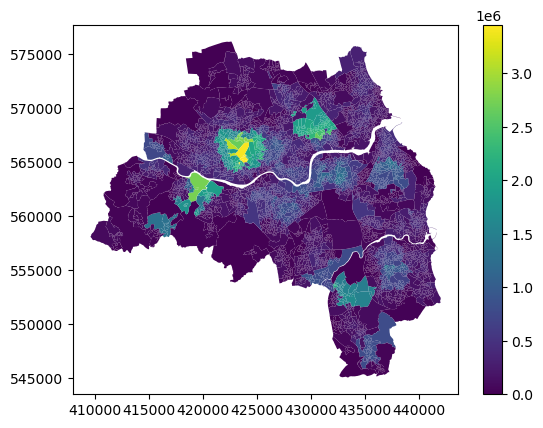

In [8]:
geom.plot(default.greenspace_accessibility.values, legend=True)

<AxesSubplot: >

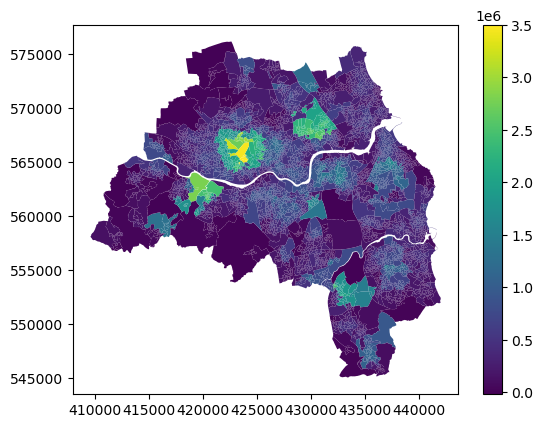

In [9]:
geom.plot(changed.greenspace_accessibility.values, legend=True)

And then check the difference between the two.

<AxesSubplot: >

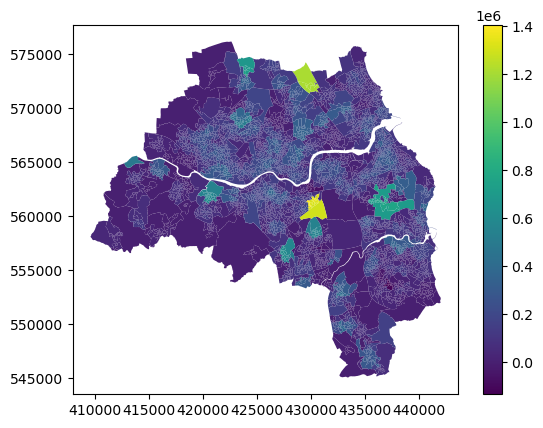

In [10]:
geom.plot(changed.greenspace_accessibility.values - default.greenspace_accessibility.values, legend=True)

The same applies to all indicators. Note that it can take a some time (10-20s) to sample values if you change many OAs.

## LSOA level

The same works on the LSOA level. The function joins the LSOA level data to OA, processes the sampling and prediction on the OA level and aggregates indicator data back to LSOA.

In [13]:
lsoa_input = pd.read_parquet("data/empty_lsoa.parquet")
lsoa_input.head()

,signature_type,use,greenspace,job_types
E01008162,None,None,None,None
E01008163,None,None,None,None
E01008164,None,None,None,None
E01008165,None,None,None,None
E01008166,None,None,None,None


If you want to redefine every LSOA (and every OA), you can specify a signature type for each. You can further specify any other input variable.

In [15]:
lsoa_input["signature_type"] = np.random.randint(0, 16, len(lsoa_input))
lsoa_input["use"] = np.random.uniform(-1, 1, len(lsoa_input))
lsoa_input["greenspace"] = np.random.uniform(0, 1, len(lsoa_input))
lsoa_input["job_types"] = np.random.uniform(0, 1, len(lsoa_input))

In [16]:
lsoa_input.head()

,signature_type,use,greenspace,job_types
E01008162,7,0.747238,0.946356,0.789177
E01008163,13,0.404831,0.036514,0.938149
E01008164,4,0.275312,0.691367,0.977162
E01008165,14,0.494970,0.021163,0.589067
E01008166,6,-0.290154,0.465899,0.426993


In [17]:
%%time
lsoa_indicators = get_indicators_lsoa(lsoa_input)

CPU times: user 11.1 s, sys: 563 ms, total: 11.7 s
Wall time: 11.6 s


As mentioned above, this takes some time as we are sampling more than 220k values. For an iterative process, it may be needed a slight refactor to ensure only the changed OAs or LSOAs are sampled and the rest remains.